# Parte 1 - Implementação de problema de FBA
## 1. Qual é a produção de lactato da estirpe selvagem?

Para avaliar a produção de lactato foi primeiro necessário definir as condições ambientes e obter a função objetivo.
As condições ambientais foram definidas como o consumo de oxigénio de 0 mmol/gDW/h e cosumo de glicose de 15 mmol/gDW/h.
Foi depois obtida a função objetivo (declaração matemática do que deve ser realizado), neste caso para a produção ótima do composto desejado.
Verificou-se que nas condições especificados não existe produção de lactato, ou seja, são produzidos 0 mm/gDW/h de lactato..

In [2]:
from reframed.io.sbml import load_cbmodel
reframed_model = load_cbmodel('../models/iML1515.xml', flavor='fbc2')

from cobra.io import read_sbml_model
model = read_sbml_model('../models/iML1515.xml')

from mewpy.simulation import get_simulator
simul = get_simulator(reframed_model)

envcond = {'R_EX_glc__D_e': (-15, 999999.0), 'R_EX_o2_e': (0, 999999.0)}

simul = get_simulator(reframed_model, envcond=envcond)
print(simul)
result = simul.simulate(method='FBA')
print(result)

dt = result.fluxes

production = 0
for i in dt:
    if i == 'R_EX_lac__L_e' or i == 'R_EX_lac__D_e':
        production += dt[i]

print("A produção de lactato para as condições ambientais de Oxigénio = 0 mmol/gDW/h e Glicose = 15 mmol/gDW/h é: {0} mmol/gDW/h.".format(production))

/usr/local/lib/python3.7/site-packages/reframed/io/sbml.py:510: UserWarning: Gene association for reaction R_PFL is not DNF
  warn(f"Gene association for reaction {reaction_id} is not DNF")
/usr/local/lib/python3.7/site-packages/reframed/io/sbml.py:510: UserWarning: Gene association for reaction R_RNDR1 is not DNF
  warn(f"Gene association for reaction {reaction_id} is not DNF")
/usr/local/lib/python3.7/site-packages/reframed/io/sbml.py:510: UserWarning: Gene association for reaction R_RNDR3 is not DNF
  warn(f"Gene association for reaction {reaction_id} is not DNF")
/usr/local/lib/python3.7/site-packages/reframed/io/sbml.py:510: UserWarning: Gene association for reaction R_RNDR4 is not DNF
  warn(f"Gene association for reaction {reaction_id} is not DNF")
/usr/local/lib/python3.7/site-packages/reframed/io/sbml.py:510: UserWarning: Gene association for reaction R_CITL is not DNF
  warn(f"Gene association for reaction {reaction_id} is not DNF")
/usr/local/lib/python3.7/site-packages/refr

objective: 0.26609812519117976
Status: OPTIMAL
A produção de lactato para as condições ambientais de Oxigénio = 0 mmol/gDW/h e Glicose = 15 mmol/gDW/h é: 0.0 mmol/gDW/h.


## 2. What are the maximum compoundproduction capabilities?

In [3]:
# identificar os metabolitos externos
reframed_model.summary()


# identificar as reações do metabolito pretendido (lactato)
reframed_model.metabolites["M_lac__L_e"]
reframed_model.metabolites["M_lac__D_e"]

# pode calcular-se a produção máxima em wildtype mantendo a função objectivo de maximização do crescimento, usando FVA
simul.FVA(reactions=['R_EX_lac__L_e', 'R_EX_lac__D_e'])
#OU

# podemos alterar a função objectivo para maximização da produção de lactato e depois analisar o fluxo minimo e maximo usando FVA
# não está completo, são duas reações objectivo
simul.objective = {'R_EX_lac__L_e': -1, 'R_EX_lac__D_e': -1}
simul.objective
simul.FVA(reactions=['R_EX_lac__L_e', 'R_EX_lac__D_e'])

Metabolites:
c 1071
e 341
p 465

Reactions:
enzymatic 1476
transport 833
exchange 337
sink 0
other 66


{'R_EX_lac__L_e': [0.0, 1.1141818181817698],
 'R_EX_lac__D_e': [0.0, 12.255999999998616]}

## 3. Use different optimization objective functionsto improve the production of  the compound, considering  that  cells  have  evolved  for  maximum growth.

In [4]:
from mewpy.optimization.evaluation import BPCY, TargetFlux, WYIELD, BPCY_FVA
from mewpy.problems import GKOProblem
from mewpy.optimization import EA
from mewpy.simulation import SimulationMethod
from mewpy.optimization import set_default_engine

print("4")
PRODUCT_ID = 'EX_lac__D_e'
BIOMASS_ID = 'Biomass_Ec_iML1515_core_75p37M'
GLUC_ID = 'EX_glc__D_e'

print("3")
evaluator_1 = BPCY(BIOMASS_ID, PRODUCT_ID, method = SimulationMethod.lMOMA)
evaluator_2 = WYIELD(BIOMASS_ID, PRODUCT_ID)
print("2")
problem = GKOProblem(model, fevaluation=[evaluator_1, evaluator_2], envcond=envcond, candidate_min_size=1, candidate_max_size=1)
print("1")
ea = EA(problem, max_generations= 10, visualizer=True, mp=True)
final_pop = ea.run()
print(final_pop)
print(len)
print(final_pop[1])
print(final_pop.values())

4
3
2
1


KeyError: 'R_EX_glc__D_e'

4
3
2
1
Running NSGAII


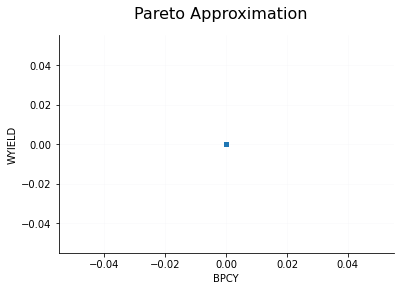

Gen    Eval|     Worst      Best    Median   Average   Std Dev|     Worst      Best    Median   Average   Std Dev|
   0    100|  0.000000  0.000000  0.000000  0.000000  0.000000|  0.000000  0.000000  0.000000  0.000000  0.000000|
   1    200|  0.000000  0.000000  0.000000  0.000000  0.000000|  0.000000  0.000000  0.000000  0.000000  0.000000|
   2    300|  0.000000  0.000000  0.000000  0.000000  0.000000|  0.000000  0.000000  0.000000  0.000000  0.000000|
   3    400|  0.000000  0.000000  0.000000  0.000000  0.000000|  0.000000  0.000000  0.000000  0.000000  0.000000|
   4    500|  0.000000  0.000000  0.000000  0.000000  0.000000|  0.000000  0.000000  0.000000  0.000000  0.000000|
   5    600|  0.000000  0.000000  0.000000  0.000000  0.000000|  0.000000  0.000000  0.000000  0.000000  0.000000|
   6    700|  0.000000  0.000000  0.000000  0.000000  0.000000|  0.000000  0.000000  0.000000  0.000000  0.000000|
   7    800|  0.000000  0.000000  0.000000  0.000000  0.000000|  0.000000  0.000

AttributeError: 'list' object has no attribute 'values'

In [3]:
from mewpy.optimization.evaluation import BPCY, TargetFlux, WYIELD, BPCY_FVA
from mewpy.problems import GOUProblem
from mewpy.optimization import EA
from mewpy.simulation import SimulationMethod

print("4")
PRODUCT_ID = 'R_EX_lac__D_e'
BIOMASS_ID = 'R_Biomass_Ec_iML1515_WT_75p37M'
GLUC_ID = 'R_EX_glc__D_e'

print("3")
evaluator_1 = BPCY(BIOMASS_ID, PRODUCT_ID, method = SimulationMethod.lMOMA)
evaluator_2 = WYIELD(BIOMASS_ID, PRODUCT_ID)
print("2")
problem = GOUProblem(reframed_model, fevaluation=[evaluator_1, evaluator_2], envcond=envcond, candidate_max_size=5)
print("1")
ea = EA(problem, max_generations= 10, visualizer=True, mp=True)
final_pop = ea.run()
print(final_pop)
print(len)
print(final_pop[1])
print(final_pop.values)

In [ ]:
final_pop[0]